In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.regularizers import l2

import matplotlib.pyplot as plt

In [2]:
tsla_filepath = os.path.join(os.getcwd(), 'tsla.csv')
goog_filepath = os.path.join(os.getcwd(), 'goog.csv')
eth_filepath = os.path.join(os.getcwd(), 'eth.csv')
btc_filepath = os.path.join(os.getcwd(), 'btc.csv')

tsla_df = pd.read_csv(tsla_filepath)
goog_df = pd.read_csv(goog_filepath)
eth_df = pd.read_csv(eth_filepath)
btc_df = pd.read_csv(btc_filepath)

In [3]:
# Function to clean data
def clean_data(df):
    df = df[['Date', 'Close']]  # Select only the 'Date' and the 'Close' column
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
    df = df.dropna().reset_index(drop=True)  # Drop rows with NaN and reset the index

    return df

In [4]:
tsla_df = clean_data(tsla_df)
goog_df = clean_data(goog_df)
eth_df = clean_data(eth_df)
btc_df = clean_data(btc_df)

<ipython-input-3-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-3-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Close'] = pd.to_numeric(df['Close'], errors='coerce')  # Convert to numeric, coercing errors
<ipython-input-3-ccee265b2116>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [5]:
btc_df

,Date,Close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3776,2025-01-18,104408.070312
3777,2025-01-19,101089.609375
3778,2025-01-20,102016.664062
3779,2025-01-21,106146.265625


In [6]:
# Function to preprocess data (splitting, scaling, and preparing training data)
def preprocess_data(data, train_split=0.7, window_size=100):
    # Splitting the data into training and testing
    data_training = data[0:int(len(data) * train_split)]
    data_testing = data[int(len(data) * train_split):]

    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_training_array = scaler.fit_transform(data_training)

    # Preparing training data
    x_train, y_train = [], []
    for i in range(window_size, len(data_training_array)):
        x_train.append(data_training_array[i - window_size:i])
        y_train.append(data_training_array[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    return x_train, y_train, data_testing, scaler

In [7]:
# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=60, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=80, activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units=120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [8]:
# Function to prepare test data
def prepare_test_data(data_testing, data_training, scaler, window_size=100):
    past_data = data_training.tail(window_size)
    final_data = pd.concat([past_data, data_testing], ignore_index=True)
    input_data = scaler.transform(final_data)

    x_test, y_test = [], []
    for i in range(window_size, len(input_data)):
        x_test.append(input_data[i - window_size:i])
        y_test.append(input_data[i, 0])

    x_test, y_test = np.array(x_test), np.array(y_test)
    return x_test, y_test

In [9]:
# Function to plot predictions with proper x-axis handling
def plot_predictions(y_test, y_predicted, scaler, test_dates, tick_interval=365):
    # Reverse scaling
    scale_factor = 1 / scaler.scale_[0]
    y_test = y_test * scale_factor
    y_predicted = y_predicted * scale_factor

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Original Price', linewidth=1)
    plt.plot(test_dates, y_predicted, label='Predicted Price', linewidth=1)

    # Formatting x-axis
    plt.xlabel('Date')  # Label for x-axis
    plt.ylabel('Price (USD)')  # Label for y-axis
    plt.title('Predicted Price vs. Actual Price')  # Add a title

    # Ensure evenly spaced x-axis ticks
    plt.xticks(test_dates[::tick_interval])  # Show every tick_interval-th date

    # Adjust x-axis limits
    plt.xlim(test_dates.iloc[0], test_dates.iloc[-1])  # Ensure the plot spans all dates

    # Add legend and show the plot
    plt.legend()
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

In [10]:
# Main function to train and test the model for a given stock
def train_and_test_lstm(stock_data, epochs=10, window_size=100):
    # Preprocessing the data
    x_train, y_train, data_testing, scaler = preprocess_data(stock_data[['Close']], window_size=window_size)

    # Building the model
    model = build_lstm_model((x_train.shape[1], 1))
    model.fit(x_train, y_train, epochs=epochs, batch_size=32)

    # Preparing test data
    x_test, y_test = prepare_test_data(data_testing, stock_data[['Close']], scaler, window_size=window_size)

    # Making predictions
    y_predicted = model.predict(x_test)

    # Extracting test dates
    test_dates = pd.to_datetime(stock_data.iloc[-len(data_testing):]['Date']).reset_index(drop=True)

    # Return the results
    return y_test, y_predicted, scaler, test_dates, model

In [11]:
def predict_future_prices(model, stock_data, scaler, last_window, prediction_intervals, frequency='Month'):
    future_predictions = []
    future_dates = []

    # Define the step size based on the frequency
    if frequency == 'Day':
        step_size = 1  # Daily
    elif frequency == 'Week':
        step_size = 7  # Weekly
    elif frequency == 'Month':
        step_size = 30  # Monthly
    else:
        raise ValueError("Invalid frequency. Use 'Day', 'Week', or 'Month'.")

    # Start from the last known date
    start_date = pd.to_datetime(stock_data['Date'].iloc[-1])

    # Calculate the number of prediction steps
    max_steps = max(prediction_intervals) // step_size

    # Predict iteratively for the required number of steps
    for step in range(max_steps):
        # Predict the next step
        next_prediction = model.predict(last_window, verbose=0)  # Suppress logging

        # Append the prediction (normalized value)
        future_predictions.append(next_prediction[0, 0])

        # Update the last_window with the new prediction
        last_window = np.append(last_window[:, 1:, :], [[[next_prediction[0, 0]]]], axis=1)

        # Append the corresponding date
        future_dates.append(start_date + pd.Timedelta(days=(step + 1) * step_size))

    # Reverse scale the predictions back to the original scale
    future_predictions = np.array(future_predictions) * (1 / scaler.scale_[0])

    # Filter predictions and dates based on specified intervals
    filtered_predictions = {
        interval: future_predictions[: interval // step_size] for interval in prediction_intervals
    }
    filtered_dates = {
        interval: future_dates[: interval // step_size] for interval in prediction_intervals
    }

    # Plot the predictions for each interval
    plt.figure(figsize=(12, 6))
    for interval in prediction_intervals:
        plt.plot(
            filtered_dates[interval],
            filtered_predictions[interval],
            label=f'Next {interval} days',
            linewidth=1,
        )

    # Formatting the plot
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.title('Future Stock Price Predictions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return filtered_predictions, filtered_dates

In [12]:
# Train the model and get data
tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tsla_model = train_and_test_lstm(tsla_df, epochs=10, window_size=100)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 29s 150ms/step - loss: 0.0075
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - loss: 0.0013
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0013
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0012
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0012
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0017
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0013
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.6979e-04
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.1942e-04
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0010
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step


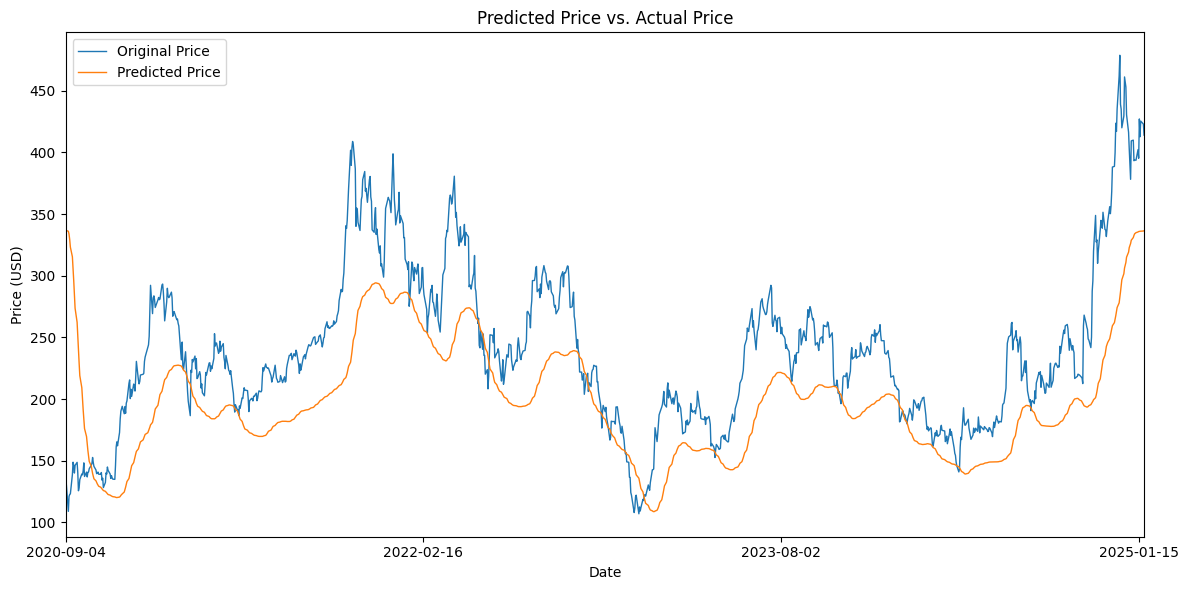

In [13]:
# Plot predictions (adjust tick_interval as needed, e.g., every 365 days)
plot_predictions(tsla_y_test, tsla_y_predicted, tsla_scaler, tsla_test_dates, tick_interval=365)

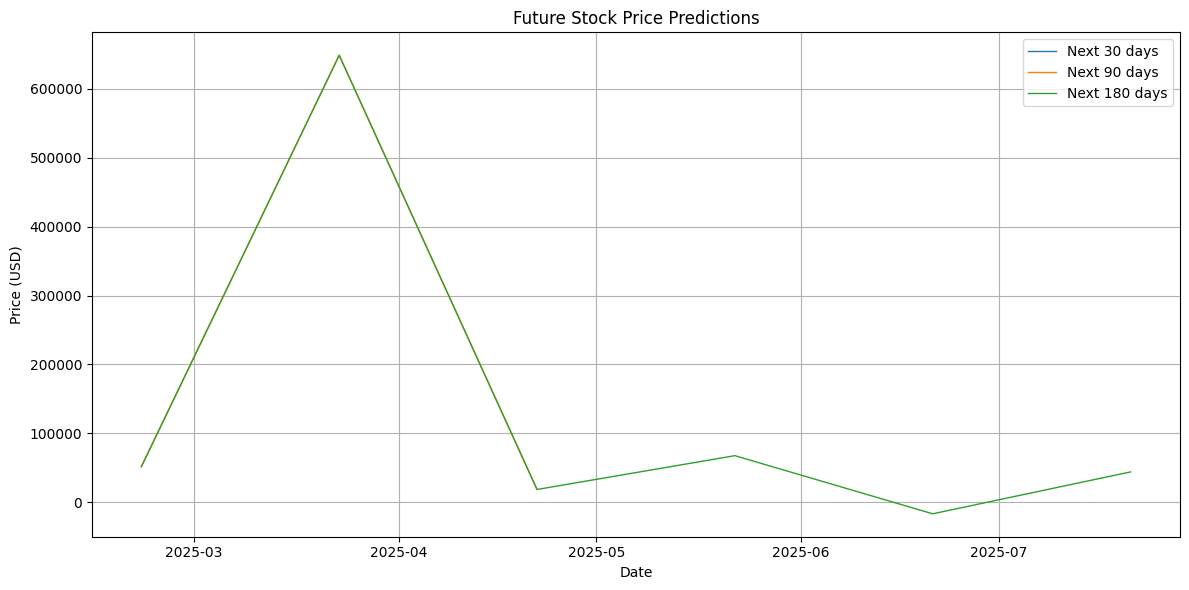

In [14]:
intervals = [30, 90, 180]  # Days for 1 month, 3 month, 6 months

# Prepare the last window of data
window_size = 100
tsla_last_window = tsla_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=tsla_model,
    stock_data=tsla_df,
    scaler=tsla_scaler,
    last_window=tsla_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

In [15]:
goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, goog_model = train_and_test_lstm(goog_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - loss: 0.0491
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0051
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0043
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0037
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0034
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0030
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0033
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0027
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0030
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0021
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step


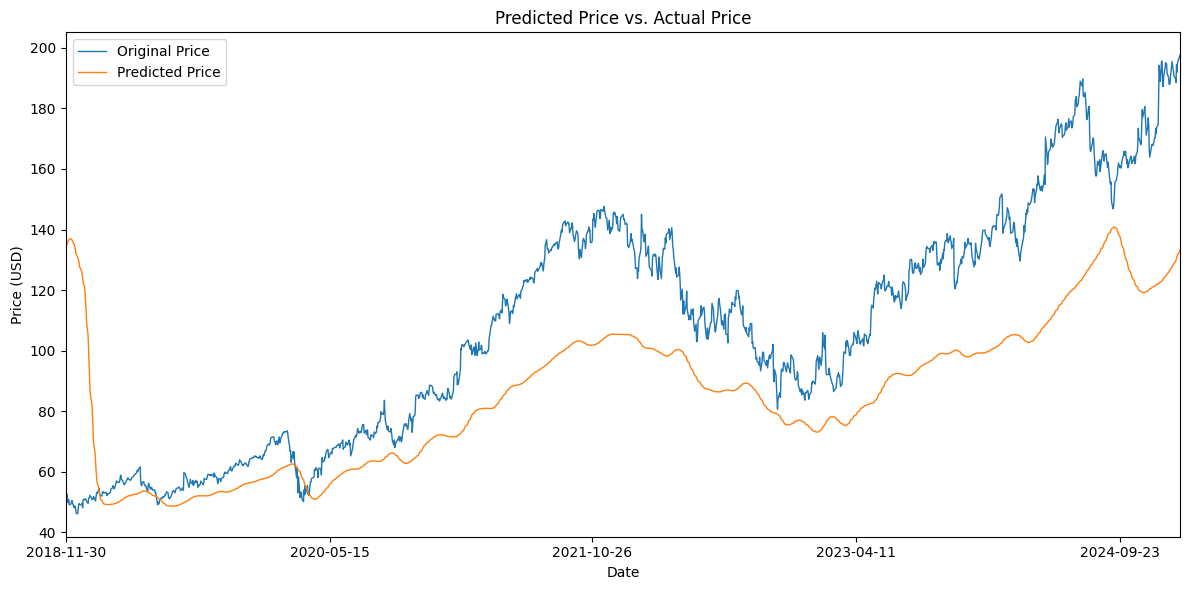

In [16]:
plot_predictions(goog_y_test, goog_y_predicted, goog_scaler, goog_test_dates, tick_interval=365)

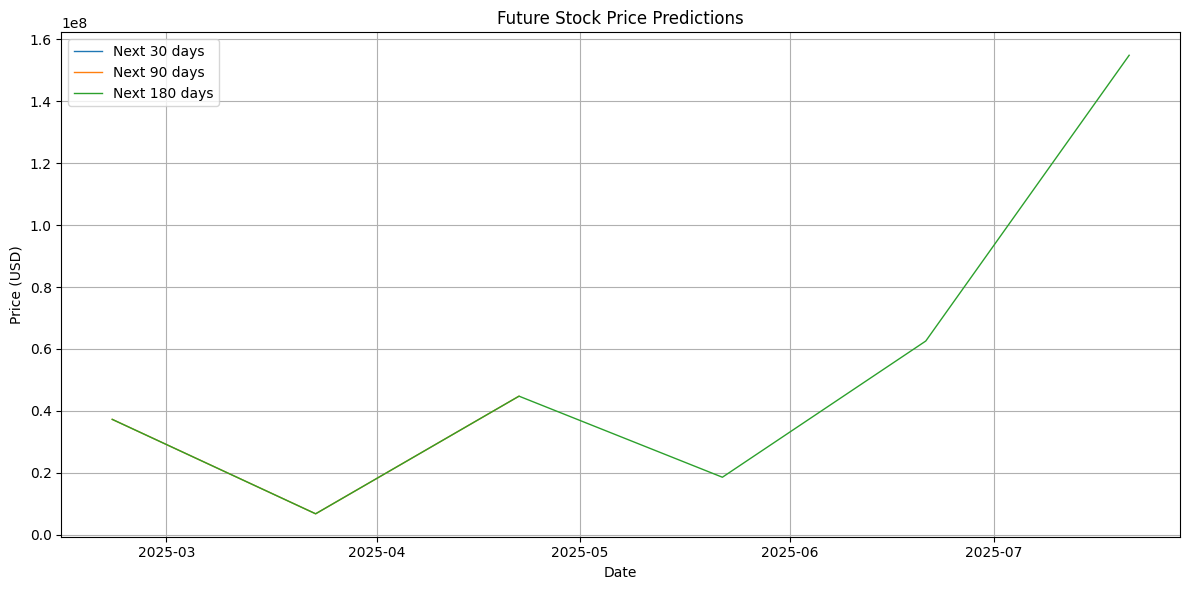

In [17]:
# Prepare the last window of data
goog_last_window = goog_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=goog_model,
    stock_data=goog_df,
    scaler=goog_scaler,
    last_window=goog_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

In [18]:
eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, eth_model = train_and_test_lstm(eth_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - loss: 0.0591
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0083
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0063
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0054
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0059
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0060
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0062
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0052
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0048
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0055
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


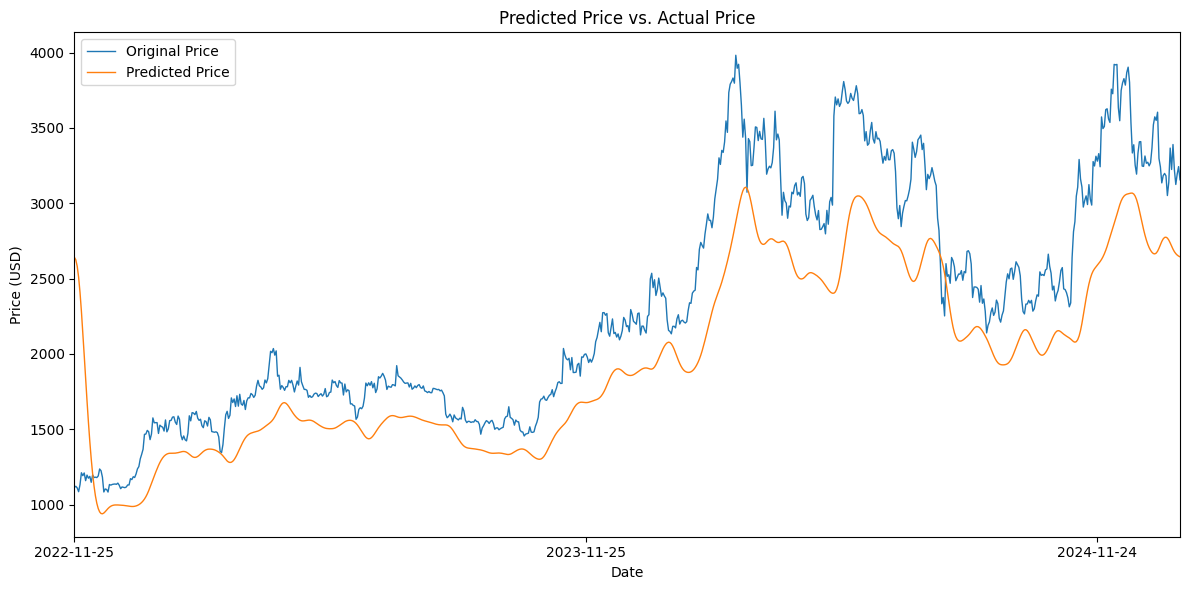

In [19]:
plot_predictions(eth_y_test, eth_y_predicted, eth_scaler, eth_test_dates, tick_interval=365)

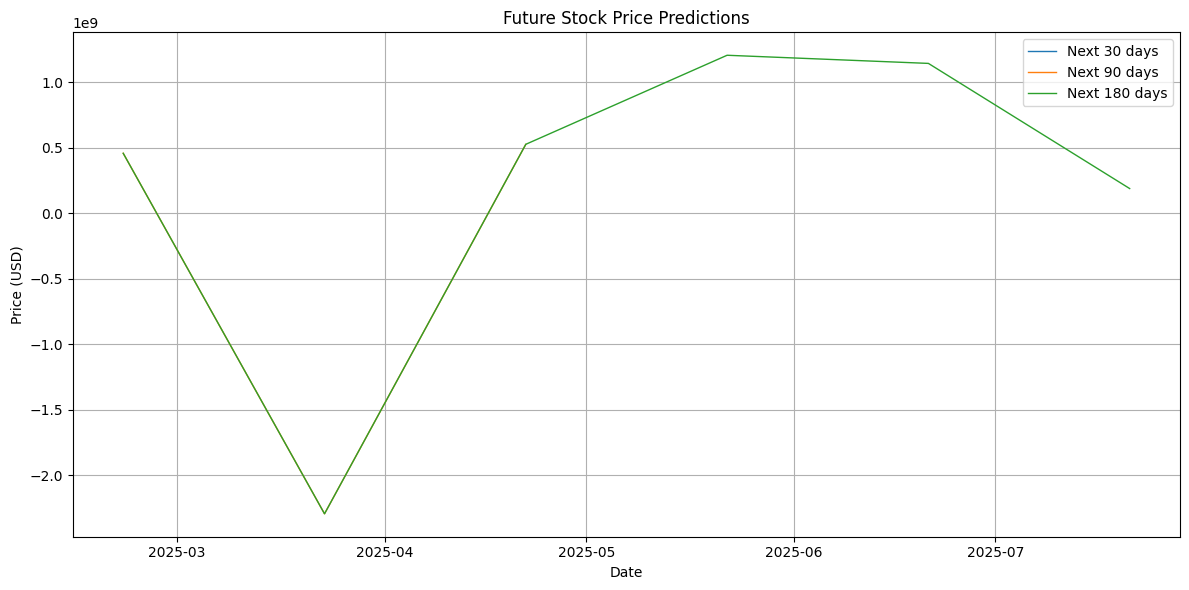

In [20]:
# Prepare the last window of data
eth_last_window = btc_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=eth_model,
    stock_data=eth_df,
    scaler=eth_scaler,
    last_window=eth_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)

In [21]:
btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, btc_model = train_and_test_lstm(btc_df, epochs=10, window_size=100)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 128ms/step - loss: 0.0448
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0045
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0040
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0032
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0032
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0031
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0035
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0031
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0029
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0032
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


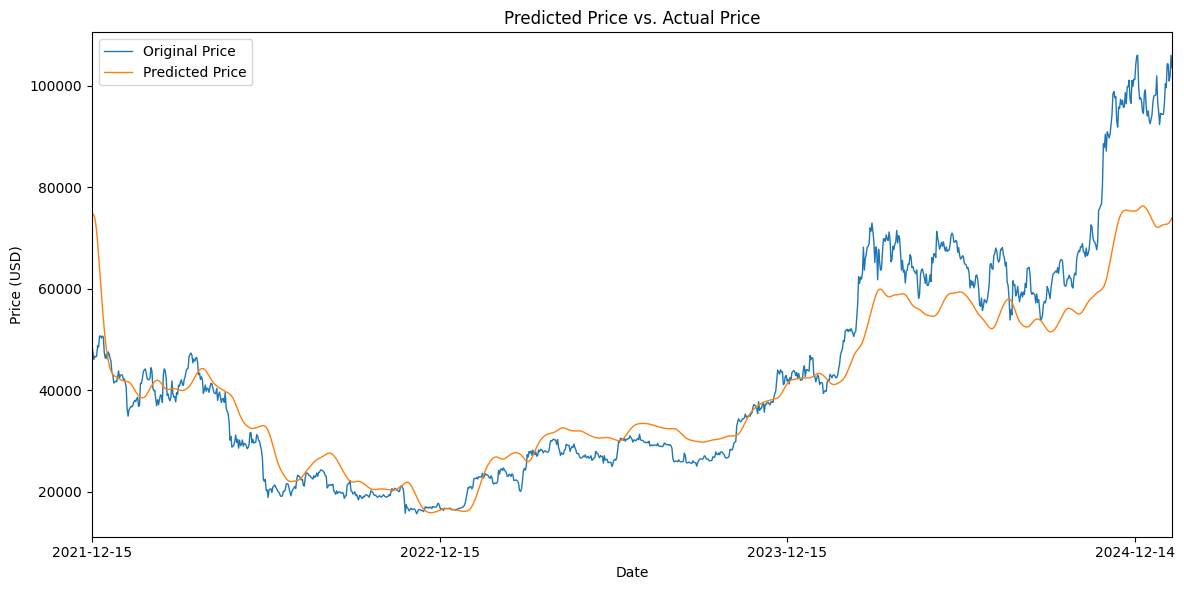

In [22]:
plot_predictions(btc_y_test, btc_y_predicted, btc_scaler, btc_test_dates, tick_interval=365)

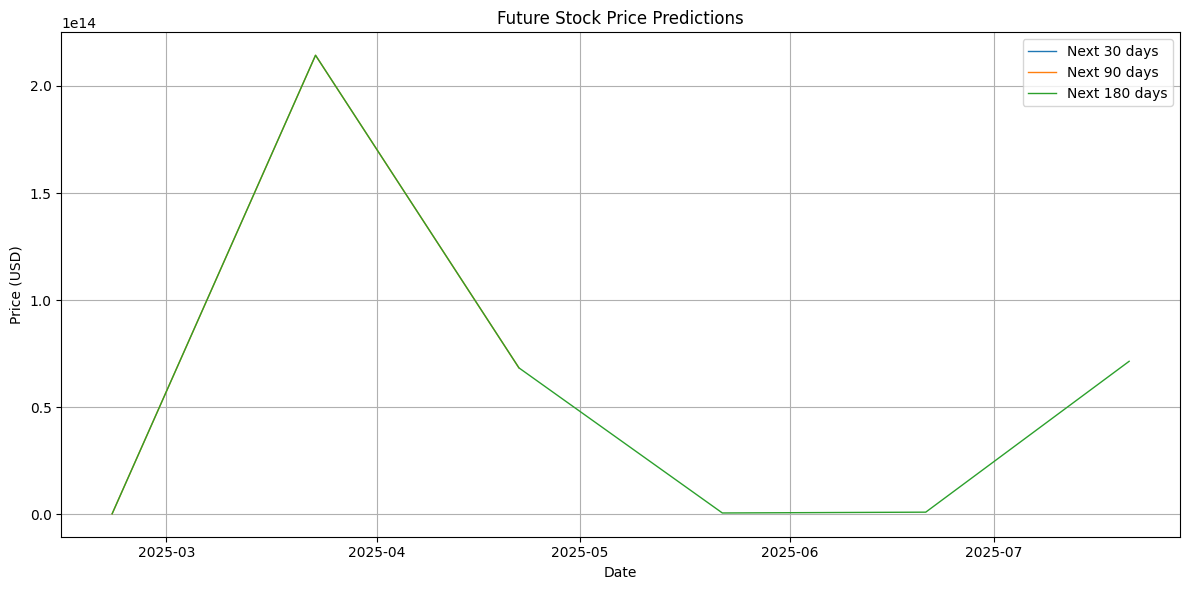

In [23]:
# Prepare the last window of data
btc_last_window = btc_df['Close'].iloc[-window_size:].values.reshape(1, window_size, 1)

filtered_predictions, filtered_dates = predict_future_prices(
    model=btc_model,
    stock_data=btc_df,
    scaler=btc_scaler,
    last_window=btc_last_window,
    prediction_intervals=intervals,
    frequency='Month',  # Monthly predictions
)